In [81]:
# load custom packages
from eda_1 import *
from eda_2 import *
from nlp import *
from data_prep import *
from model_selection import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Network Growth in Venmo:
## *Predicting drivers of growth in event-based social payments networks*


*Procedure:* 

**1. Overview of the problem**

**2. Acquire the data**

**3. Exploratory Data Analysis**

**4. Data Preparation (includes NLP)**

**5. Complete Data Visualizations**

**6. Predicting Recruiting Transactions with Machine Learning**

**7. Conclusion**


## 1. Overview of the Problem

*Problem:*

**Why do users join Venmo's network?**

![alt text](https://drive.google.com/uc?id=1ErpyqGzkKFVji262pCMHnKTq4XJhn1Oj)
*Background:*

**Network effects** are very important when it comes to payments. The usefulness of a payments network comes in part from its convenience to its members. The more connections a payment network has, the more destinations a member can send money to or receive money from. More potential connections in turn attracts more users which means even more potential connections, financial transactions and data. In short, adding users potentially sets off an exponential growth cycle thanks to network effects.


One of the ways a payments network can gain new users (i.e. expand the network) is by making its network the preferred way to purchase a popular good. These goods are called **"pull-goods"** because they "pull" users into the network. Airline tickets are a good example. Card companies know that buying airline tickets is common and usually easier with plastic than with cash so they target their advertisements towards vacations and flying abroad. If the advertising is successful, users apply for credit cards (join the network) in part because they think it will make traveling easier and the credit card network expands in tandem with air travel. Visa's motto alludes to this as well as network effects. "Everywhere you want to be," not only highlights the value of ubiquity; it also associates the Visa payments network with a key pull-good.


**Identifying pull-goods is a crucial task for payments networks looking to target their advertising in order to profit from network effects. In the case of Venmo, such identification is tricky.** Unlike credit cards payments, Venmo transactions do not require a receipt from the payee officially stating why the transaction took place. Instead, there is message sent by the payer to the payee which may or may not include a reason for its occurence. Even assuming that the message explains why it happened, the payer can write the message in thousands of ways making a word search for potential pull-goods (e.g. "rent," "drink," ...etc.) inadequate. Presumably, the payee can infer the transaction's purchase from this message so a human analyst at Venmo might be able to as well. With millions of transactions per week however, such analysis by human eyes is not feasible. 

*TL;DR*

**This analysis seeks to use machine learning to identify the topics of Venmo transaction messages and find their correlation (if any) with the arrival of new Venmo users. In other words, it aims to provide a scaleable way for Venmo to discover pull-goods. As discussed earlier, more precise information can facilitate more precise advertisement (or other incentive systems) and thus a faster, more efficient expansion of Venmo's network.**

### Assumptions
1. The public transactions from Venmo's API are put there when they happen and are therefore roughly representative.
2. If the amount of transactions scraped per day is roughly the same for consecutive days, the data was scraped randomly and is roughly representative

## 2. Acquire Data

Public access to venmo data is severely restricted. Because of this, getting large amounts of data in a short amount of time meant compromising in terms of control. The data used here was scraped over roughly 7 months. We assume that minimal variance at high volume is the most representative (i.e. Mr. Salmon left his scraper on to take whatever appeared on the public feed). This data and its documentation is available [here](https://github.com/sa7mon/venmo-data).

In [3]:
all_raw_data = bson_decode('data/venmo.bson')

0 done
1000000 done
2000000 done
3000000 done
4000000 done
5000000 done
6000000 done
7000000 done


In [4]:
all_raw_data.shape

(7076585, 14)

In [5]:
all_raw_data.columns

Index(['payee', 'payee_name', 'payer', 'payer_name', 'merchant',
       'transaction_type', 'date', 'transaction_id', 'payee_join_date',
       'payer_join_date', 'date_completed', 'note', 'app_name', 'app_id'],
      dtype='object')

In order find out which transactions are bringing in new users, the data has to be sorted sequentially.

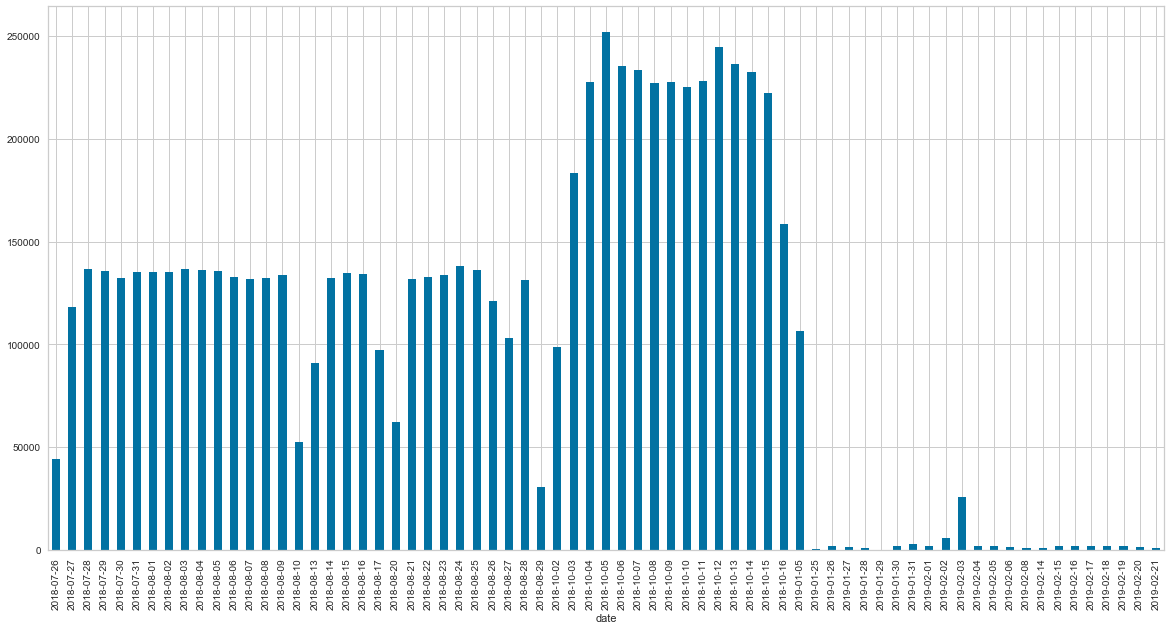

In [6]:
# Sort data and confirm visually
sorted_df = date_sort_delay(all_raw_data)
data_dates_viewer(sorted_df)

In order to mimic Venmo analysts and to get the most data possible, we'll choose to take our sample of the data from the first half of October. We assume this section is the most representative of a chunk of data Venmo analysts would have access to.

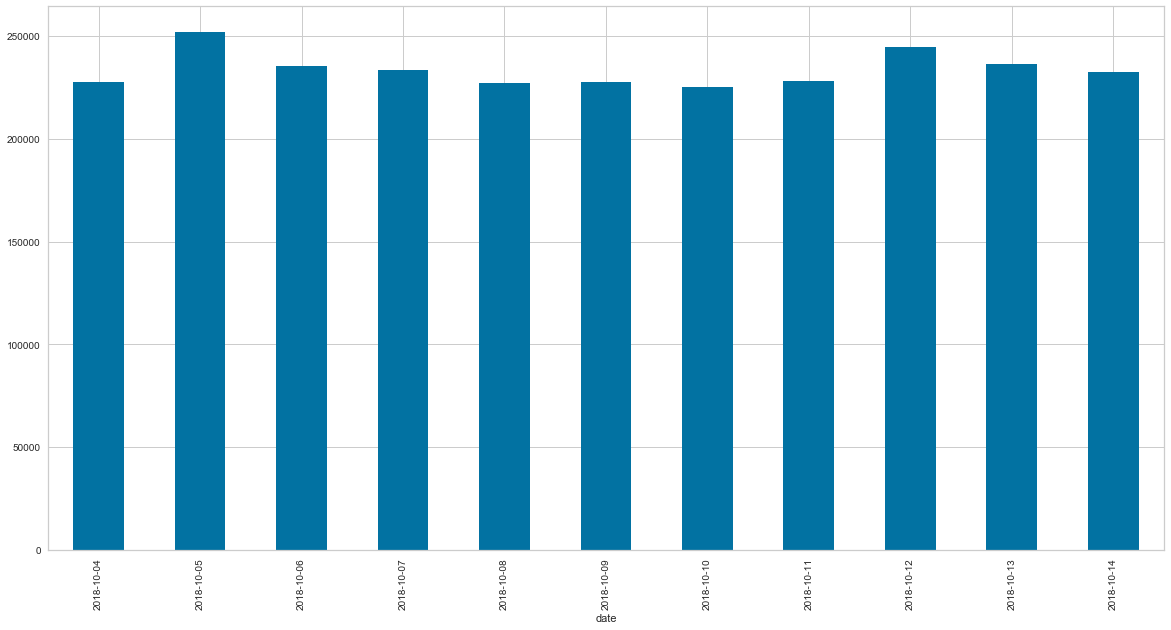

In [7]:
# select highest density to split and confirm visually
start = '2018-10-04'
stop = '2018-10-15'
sorted_selection = date_slicer(sorted_df, start, stop)
data_dates_viewer(sorted_selection)

In [ ]:
#set first transaction date and split the data to prevent leakage
train, test = percent_splitter(sorted_selection, 70)

## 3. Exploratory Data Analysis

In [ ]:
# make copy
venmo_train = train.copy()

In [ ]:
# basic info
venmo_train.info()

In [ ]:
# find missing
msno.matrix(venmo_train);

It looks like *merchant* is missing as well as a little bit of user metadata.

In [ ]:
# check for duplicates
venmo_train[venmo_train.duplicated()].shape

In [ ]:
# add target variables ('join', 'recruiting', and 'who_joined') based on date
attr_adder = LabelAdder() 
labeled = attr_adder.transform(venmo_train)

#### EDA of Outcome Variable: *Join*

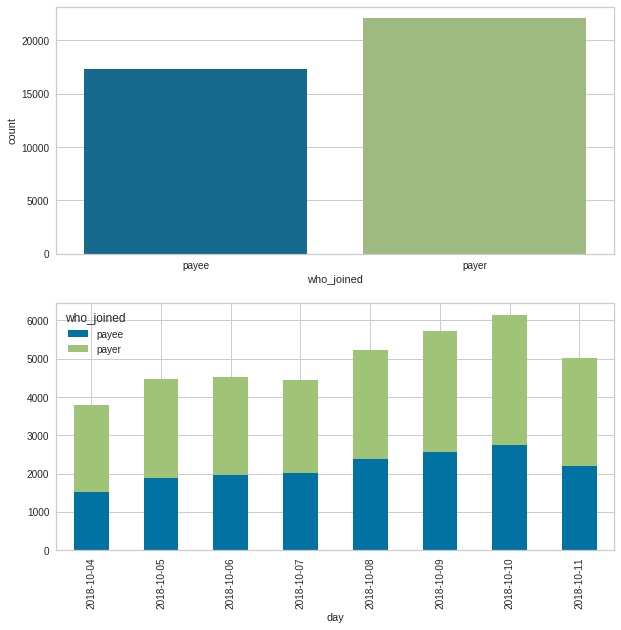

In [ ]:
joined = labeled.loc[labeled['join'] == 1].copy()
joined['day'] = joined['date'].dt.date
joined_plot = joined.groupby(['who_joined', 'day']).size().reset_index().pivot(
    columns='who_joined', index='day', values=0)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.countplot(joined['who_joined'], ax=ax[0])
joined_plot.plot(kind='bar', stacked=True, ax=ax[1])
plt.show()

- Slightly more people joined Venmo as payers instead of payees
- This does not seem to vary widely based on the date (see correlation matrix Stage 4)

#### EDA of Key Variable: *date*

In [10]:
# describe key variable (date)
labeled[['payee_join_date', 'payer_join_date']].describe().T

,count,unique,top,freq,first,last
payee_join_date,1785544,1408288,2016-11-03 17:05:18,240,2009-10-19 05:10:47,2018-10-12 00:45:56
payer_join_date,1785544,1474209,2016-09-27 23:46:35,187,2009-07-20 15:56:50,2018-10-12 00:48:44


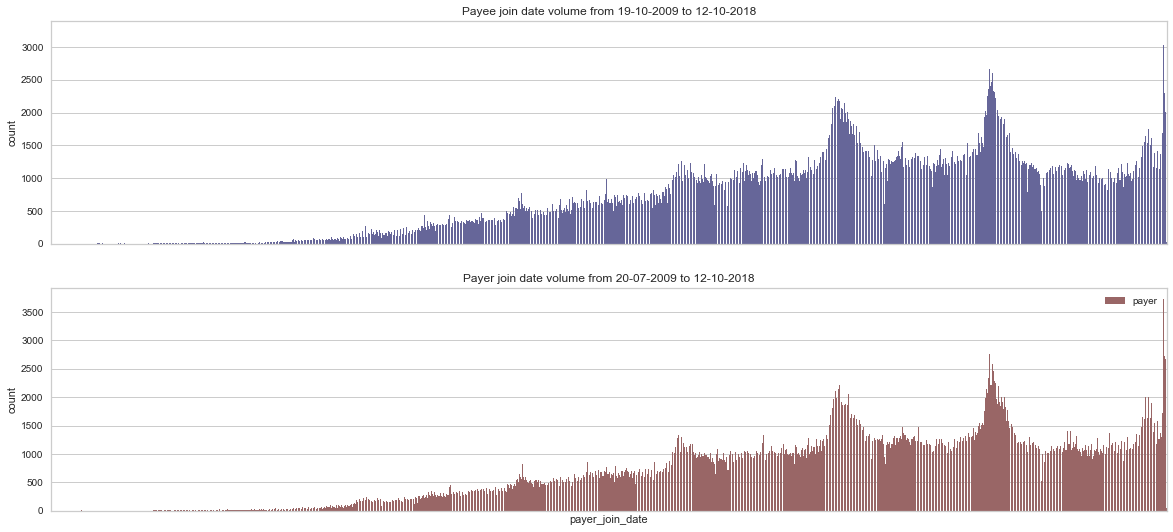

In [11]:
import matplotlib.dates as mdates
months = mdates.MonthLocator()
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.countplot(labeled['payee_join_date'].sort_values().dt.date,  ax=ax[0],
              color='blue', saturation=0.2, label='payee')
ax[0].set_title('Payee join date volume from 19-10-2009 to 12-10-2018')
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_major_formatter(years_fmt)
ax[0].format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax[0].grid(True)
sns.countplot(labeled['payer_join_date'].sort_values().dt.date, color='red',
              saturation=0.2, label="payer", ax=ax[1]) ,
ax[1].set_title('Payer join date volume from 20-07-2009 to 12-10-2018')
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_major_formatter(years_fmt)
ax[1].format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax[1].grid(True)
fig.autofmt_xdate()
plt.legend()
plt.show()

In [12]:
labeled.payee_join_date.dt.date.value_counts()[0:3]

2017-08-27    3232
2018-10-05    3028
2018-10-04    2750
Name: payee_join_date, dtype: int64

In [13]:
labeled.payer_join_date.dt.date.value_counts()[0:3]

2018-10-05    3734
2018-10-04    3386
2018-10-06    3277
Name: payer_join_date, dtype: int64

Expected:
- visually payee and payer data share similar, but not identical patterns of joining venmo


Points of concern: 
- 5 of the 6 most popular dates to join are singular spikes within the training data


The pattern shows a growing network which suggests our data is at least somewhat representative. The late uptick in new users may mean that our October subsection of data is atypical and any model may be less robust.

#### EDA of Key Variable: *note*

In [14]:
print(f'{labeled.note.nunique()} unique values for notes')
print(f'Unique values make up {np.round(labeled.note.nunique()*100/labeled.shape[0], 2)}% of the notes')

765421 unique values for notes
Unique values make up 42.87% of the notes


In [15]:
# Top values
print(labeled.note.value_counts()[0:9])
print(f'The top 10 notes make up {np.round(sum(labeled.note.value_counts()[0:9]/labeled.shape[0]), 2)}% of the notes')

Food      20359
🍕         14346
⛽          8269
:uber:     7469
🏠💸         7430
Uber       6184
🍴          5925
🍺          5834
❤️         5399
Name: note, dtype: int64
The top 10 notes make up 0.05% of the notes


There is a vast array of different messages with nearly half of the total messages being unique. Food, petrol, transport, rent, drinks, relationships are all reasons suggested by the top 10 messages; but as these only make up 4.5% of the data, they may not be representative. We will revisit this after using NLP to sort *note* algorithmically into 20 topic-clusters.

#### EDA of Key Variable: *app_name*

In [16]:
labeled.app_name.value_counts()

Venmo for iPhone                              1565283
Venmo for Android                              213743
splitwise                                        3904
Venmo.com                                        2418
venmo payouts                                     127
tab                                                47
Venmo Developer                                    15
BottleRocketUtility                                 3
drupe                                               2
Georgetown University Alumni & Student FCU          1
Developer Settings                                  1
Name: app_name, dtype: int64

Unsurprisingly, the main venmo platforms are iPhones and Android-based smartphones. For simplicity, we'll bin these into three categories (*iphone*, *android*, *other*) in the 4th stage.

#### EDA of Key Variable: *age*

In [17]:
labeled.age.describe().T

count    1.785544e+06
mean     8.903280e+02
std      4.560778e+02
min     -1.000000e+00
25%      5.380000e+02
50%      8.440000e+02
75%      1.204000e+03
max      3.368000e+03
Name: age, dtype: float64

In [20]:
print(f'Transactions in which both users joined on the same day make up {np.round(labeled[labeled.age == -1].shape[0]/labeled.shape[0], 4)}% of the transactions')

Transactions in which both users joined on the same day make up 0.0004% of the transactions


We'll drop the -1 (both the payee and payer joined on the same day) as they make up a tiny fraction of the population in the next stage.

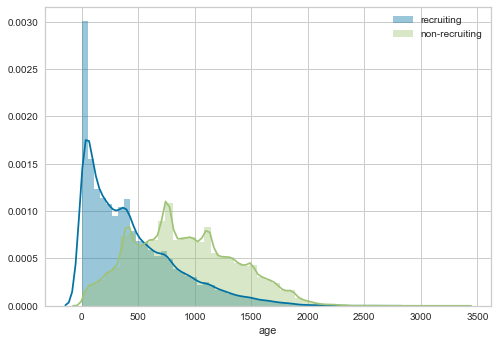

In [71]:
sns.distplot(labeled[labeled['join']==1]["age"], label='recruiting')
sns.distplot(labeled[labeled['join']==0]["age"], label='non-recruiting')
plt.legend()
plt.show()

There is a stark difference between the *age* (days on the network) of users involved in bringing in new users and the *age* of users in non-recruiting transactions.

*Note:* The *age* variable looks at the join date of the oldest user in a transaction so does not count newest users. However, it may still take into account first-time users if they joined Venmo before the other user in the transaction. This may explain the differences in skew.

#### Correlation matrix of key variables and target (before NLP)

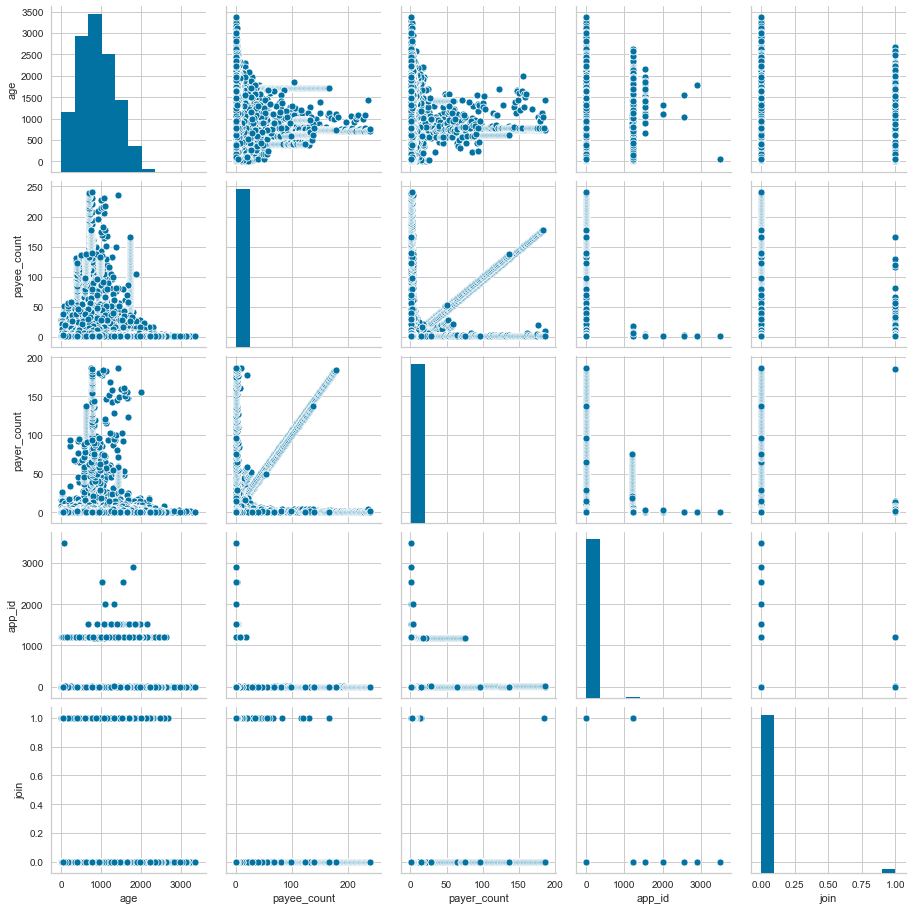

In [6]:
attributes = ["age", "payee_count", "payer_count", "app_id", "join"]
sns.pairplot(labeled[attributes])
plt.show()

Expected:
- normal distribution of the length of time users have been on Venmo (*age*)
- correlation between how many times payers and payees have used Venmo before prior to the transaction (*payee_count* and *payer_count*)


Points of concern:
None (feedback welcome)

## 4. Data Preparation

#### Creating the Primary Variable using NLP

We use a GSDMM unsupervised learning to generate a model that can sort Venmo notes into 20 topics. 20 is an arbitrary number (a range between 5 and 100 were tried) that generates the most robust model.

In [ ]:
# build GSDMM model to sort notes into 20 topics
full_chunk_train, full_dic_train = create_chunk_and_diction(labeled) # clean and split notes into tokens and dictionary
big_copy_train = blank_filler(full_chunk_train, full_dic_train) # fill in blank tokens
mpg_20 = mpg_tester(big_copy, 20) #generate NLP unsupervised model for use on test

done demojizing
done with stop_words
replaced :
stripped notes
finished chunk 25 and 595200 notes, 50 chunks to go
finished chunk 50 and 1190400 notes, 25 chunks to go
finished chunk 75 and 1785600 notes, 0 chunks to go
finished 1785544 notes in total
86558


In [ ]:
# assign topics and topic certainty to notes
add_on_20 = topic_builder(mpg_20, big_copy_train, 20)

In [9]:
# add on NLP columns
labeled_reset = labeled.reset_index()
labeled_nlp = pd.concat([labeled_reset, add_on_20], axis=1)

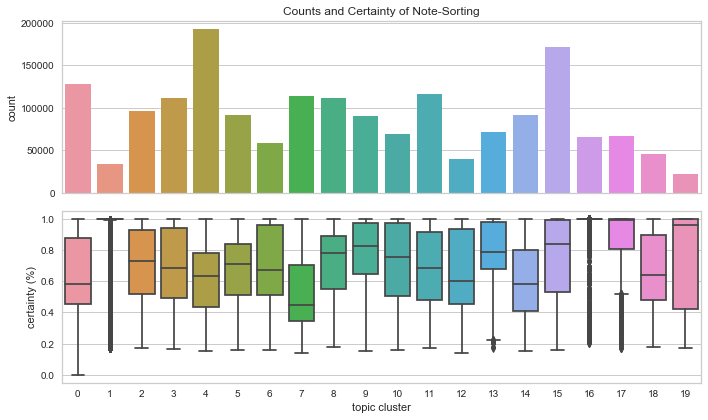

In [11]:
# visualize primary variable
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.countplot(x='topic_cluster_20', data=labeled_nlp, ax=ax[0])
ax[0].get_xaxis().set_visible(False)
sns.boxplot(x='topic_cluster_20', y='certainty_20', data=labeled_nlp, ax=ax[1])
ax[0].set_title('Counts and Certainty of Note-Sorting')
ax[1].set_ylabel('certainty (%)')
ax[1].set_xlabel('topic cluster')
plt.tight_layout()
plt.show()

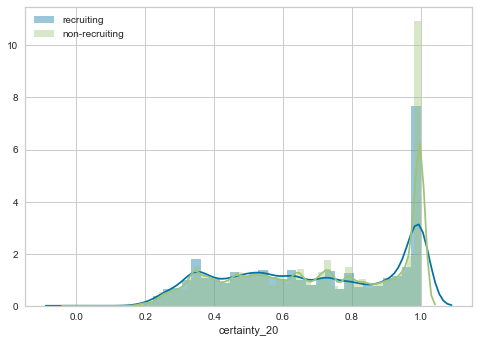

In [76]:
sns.distplot(relevant_joins["certainty_20"], label='recruiting')
sns.distplot(relevant_norms["certainty_20"], label='non-recruiting')
plt.legend()
plt.show()

No clear difference in certainty abouttopic placement for recruiting and non-recruiting transactions. Certainty does vary across the 20 clusters with *topic_cluster_20_7* looking the most difficult to place.

#### Transform Variables (*weekday*, *app*, and *frequency*)

In [13]:
add_var = AddVariables()
complete = add_var.transform(labeled_nlp)

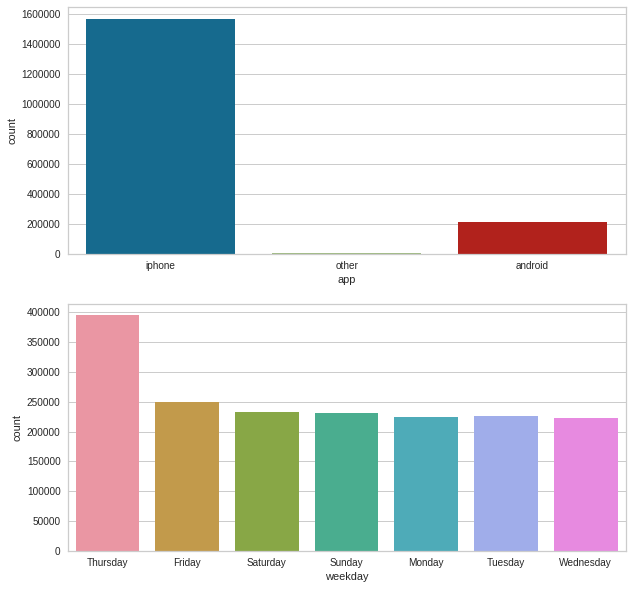

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
sns.countplot(x='app', data=complete, ax=ax[0])
sns.countplot(x='weekday', data=complete, ax=ax[1])
plt.show()

- The Venmo App for iPhones is the most popular in our sample. This is more than 45%, [the current proportion of iPhone users in the USA](https://www.statista.com/statistics/236550/.percentage-of-us-population-that-own-a-iphone-smartphone/)
- Thursday is the most popular day to use Venmo in our sample, but otherwise transactions are evenly dispursed

#### Drop Irrelevant/Useless Data

In [14]:
complete_clean = complete[complete.age != -1]

In [16]:
complete_relevant = complete_clean[['age', 'topic_cluster_20', 'certainty_20',
                      'frequency', 'weekday', 'app', 'join']].copy()
complete_relevant.shape

(1784853, 7)

#### Add Dummies

In [17]:
completely_ready = pd.get_dummies(complete_relevant, columns=['topic_cluster_20',
                                                 'weekday', 'app'])

In [21]:
# Split data
X_train = completely_ready.drop(['join'], axis=1)
y_train = completely_ready['join'].copy()

## 5. Complete Data Visualizations

In [65]:
relevant_joins = completely_ready[completely_ready['join'] == 1]
relevant_norms = completely_ready[completely_ready['join'] == 0]

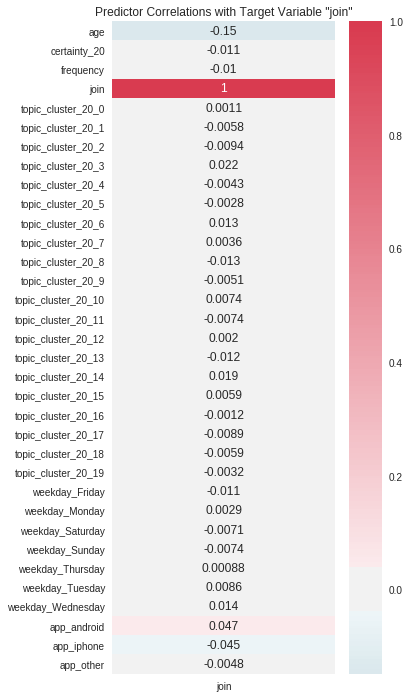

In [38]:
fig, ax= plt.subplots(figsize=(5,12))
sns.heatmap(pd.DataFrame(corr['join']), cmap=cmap, center=0, annot=True)
ax.set_title('Predictor Correlations with Target Variable "join"')
plt.show()

- Aside from Android use and age, there appear to be no serious linear correlations.

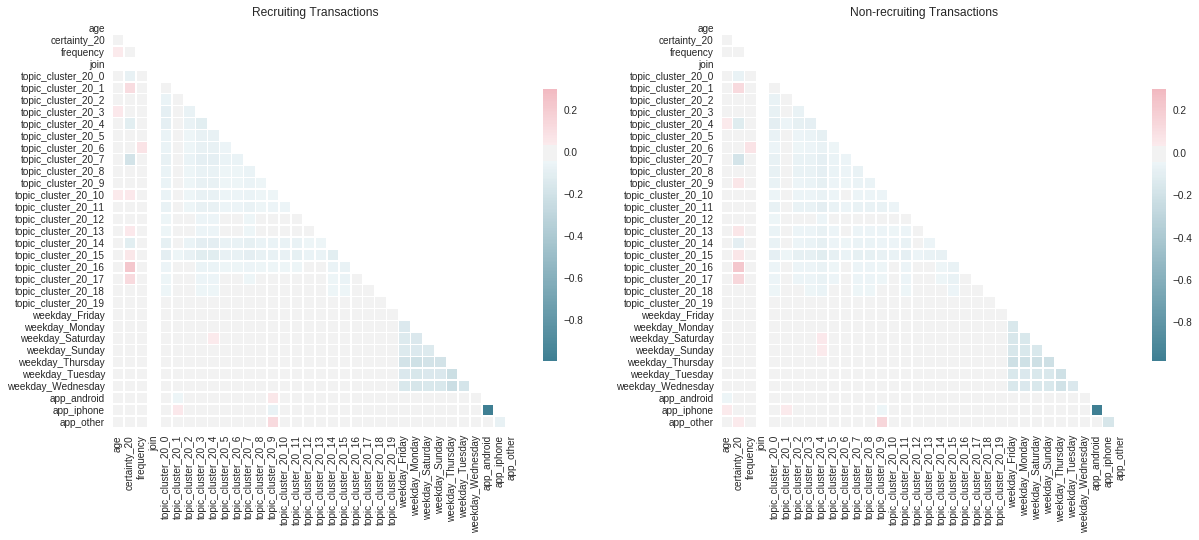

In [35]:
corr_joins = relevant_joins.corr()
corr_norms = relevant_norms.corr()

mask_joins = np.triu(np.ones_like(corr_joins, dtype=np.bool))
mask_norms = np.triu(np.ones_like(corr_norms, dtype=np.bool))

f, ax = plt.subplots(1, 2, figsize=(20, 10))

cmap = sns.diverging_palette(220, 8, as_cmap=True)

sns.heatmap(corr_joins, mask=mask_joins, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[0])
ax[0].set_title('Recruiting Transactions')
sns.heatmap(corr_norms, mask=mask_norms, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])
ax[1].set_title('Non-recruiting Transactions')
plt.show()

- Between the recruiting and non-recruiting transactions, only *topic_cluster_20_9* vs *app_android* as well as *age* look different, but not by much.

**Outlook for model selection**: So far there have been no clear patterns that differentiate the "pulling" transactions. Model selection will likely have low scores. A dummy random dataframe should be tested for comparison. 

## 6. Predicting Recruiting Transactions with Machine Learning

**Handling Class Imbalance**:

Because positives (recruiting transactions) make up only 2% of the total, several measures were taken. These include:

1. Scoring changed to Area Under the Precision-Recall Curve (AUPRC). This deals better with severe class imbalance ([*Davis & Goadrich, 2006*](https://www.biostat.wisc.edu/~page/rocpr.pdf)) as this focuses on correct identification of positives.

2. Both oversampling using SMOTE and weighting were compared on all 10 models. Weighting turned out to be more robust (and interpretable).

3. XGBoost showed the best, albeit still very modest results with a **15.8% AUPRC**

In [ ]:
# transform test data using training data steps
test_ready = transform_test_data(test)

In [ ]:
# split
X_test = test_ready.drop(['join'], axis=1)
y_test = test_ready['join']
predictors = list(X_test.columns)

In [47]:
# set model
weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
xgb_final = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 2,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = 3,
    scale_pos_weight = weights)

In [48]:
xgb_final = modelfit(xgb_final, completely_ready, predictors, 'join')

In [49]:
probs = xgb_final.predict_proba(X_test)[:,1]

In [45]:
print(f'AUROC: {metrics.roc_auc_score(y_test, probs)}')
print(f'AUPRC: {average_precision_score(y_test.values, probs)}')

AUROC: 0.7896858689167339
AUPRC: 0.15794105927097024
APS: 0.15794105927097024


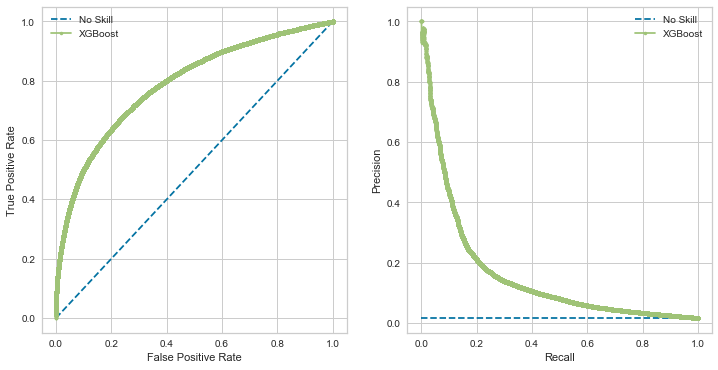

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, _ = metrics.roc_curve(y_test, probs)
ax[0].plot(fpr, tpr, marker='.', label='XGBoost')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend()
no_skill = len(y_test[y_test == 1]) / len(y_test)
ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = precision_recall_curve(y_test, probs)
ax[1].plot(recall, precision, marker='.', label='XGBoost')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend()
plt.show()

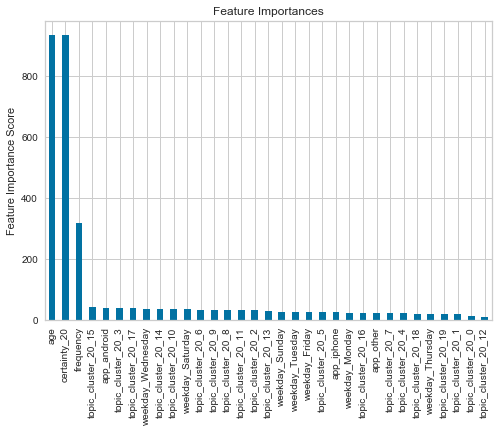

In [51]:
feat_imp = pd.Series(xgb_final.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## 7. Conclusion

*Problem:*

**Why do users join Venmo's network?**

*Short Answer:*

*"Because their friend joined recently as well"* looks to be the most likely answer, though there is still some evidence of a link between messages sent and recruitment.

*Age* (i.e. number of days since the older user in a transaction joined Venmo) the most important factor in our most accurate model and there is a clear difference in the distributions between transactions that brought in new users ("recruiting") and those that did not. **The length of time a user has been on Venmo was the most important factor. Recruiting transactions are positively correlated with newer users.**

Although none of the topics sorted showed any clear correlation or predictive value towards our outcome variable, our NLP algorithm's certainty about their placement (*certainty_20*) was equally important. Unlike age, the differences between certainty for recruiting and non-recruiting transactions is not obvious. Moreover, there is no clear correlation between *age* and *certainty_20*. In short, it is still very possible that there is a correlation between the topic of a transaction and whether or not that transaction pulls in a new user.

*Recommendations to Venmo:*

- Target new users with benefits for bringing in others as they seem the most likely to expand the network

*Next Steps:*

1. Add in topological features for each transaction based on graph structure. *Currently in process.*

2. Test more topic numbers for the GDSMM model to find the optimal topic number for yielding maximum AUPRC.

3. Try other sections of the data (August looks consistent) to add more data for training. Handling larger data will slow an already slow process (another reason for sticking with 11 days in October).

*Limitations:*

- As stated before, we did not gather this data so cannot be sure of how accurately it represents typical Venmo transactions

- Accuracy for the topic sorting is based on judgement rather than a standard cohesion vs. separation metric (e.g. a silhouette coefficient). This is due to time constraints and the relative novelty of the NLP algorithm.